### Train - Test 교차 검증 실험

In [1]:
import pandas as pd

origin_data1 = pd.read_csv('data2/CGM1_dS&dSr.csv', encoding='cp949')
origin_data2 = pd.read_csv('data2/CGM2_dS&dSr.csv', encoding='cp949')
origin_data3 = pd.read_csv('data2/CGM3_dS&dSr.csv', encoding='cp949')
origin_data4 = pd.read_csv('data2/CGM4_dS&dSr.csv', encoding='cp949')
origin_data5 = pd.read_csv('data2/CGM5_dS&dSr.csv', encoding='cp949')

def filter_data(origin_data, columns):
    data = origin_data[columns]
    data = data[data["Glu(mg/dl)"] > 0]
    return data

In [2]:
target_var = ["Glu(mg/dl)",
               "R-rPDdSr31", "R-rPDdSr32", "R-rPDdSr21",
               "T-rPDdSr31", "T-rPDdSr32", "T-rPDdSr21",
               "R-rPD_L2dS", "T-rPD_L2dS", "T-rPD_L3dS"]
dataR1 = filter_data(origin_data1, target_var)
dataR2 = filter_data(origin_data2, target_var)
dataR4 = filter_data(origin_data4, target_var)
dataR5 = filter_data(origin_data5, target_var)

In [3]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def preprocess(train_data, test_data) -> tuple:
    train_data = train_data.astype({'Glu(mg/dl)':'int'})
    test_data = test_data.astype({'Glu(mg/dl)':'int'})
    
    X_train = train_data.drop('Glu(mg/dl)', axis=1).values
    y_train = train_data['Glu(mg/dl)'].values
    y_train = y_train.round(0)
    
    X_test = test_data.drop('Glu(mg/dl)', axis=1).values
    y_test = test_data['Glu(mg/dl)'].values
    y_test = y_test.round(0)
    
    sum_data = pd.concat([train_data, test_data])
    sum_data = sum_data.drop('Glu(mg/dl)', axis=1).values
    
    scaler = StandardScaler()
    print(len(sum_data))
    scaler.fit(sum_data)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return torch.tensor(X_train, dtype=torch.float32), \
        torch.tensor(y_train, dtype=torch.float32), \
        torch.tensor(X_test, dtype=torch.float32), \
        torch.tensor(y_test, dtype=torch.float32)

dataC= pd.concat([dataR1, dataR2, dataR4])
datas = preprocess(dataC, dataR5)

913


In [4]:
from torch import onnx

def train_model(model, train_loader, num_epochs, learning_rate, name:str):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    epoch_losses = []
    for epoch in tqdm(range(num_epochs), desc=f'Train {name}'):
        total_loss = 0
        total_batches = 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            with torch.set_grad_enabled(True):
                y_hat = model(X)
                loss = criterion(y_hat.squeeze(), y)
                total_loss += loss.item()
                total_batches += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = total_loss / total_batches
        epoch_losses.append(epoch_loss)
    
    torch.save(model.state_dict(), f'property2/{name}.pt')
    onnx.export(model, X.to(device), f'property2/{name}.onnx')
    return epoch_losses

In [5]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 8
num_epochs = 100
learning_rate = 0.001

train_loader = DataLoader(TensorDataset(datas[0].unsqueeze(1), datas[1]), batch_size=batch_size, shuffle=True)

In [6]:
from model import MLP, Conv1DModel, LinearRegressionModel

model_linear = LinearRegressionModel(9, 1, "sum")
losses_linear = train_model(model_linear, train_loader, num_epochs, learning_rate, 'linear')

model_conv = Conv1DModel(1, 2)
losses_conv1d = train_model(model_conv, train_loader, num_epochs, learning_rate, 'conv1d')

model_mlp = MLP(9)
losses_mlp = train_model(model_mlp, train_loader, num_epochs, learning_rate, 'mlp')

Train conv1d: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]
C:\Work\CGM\ETRI_CGM_Analysis_ModelDev\JaeseongArea\model\_1d_conv_net.py:28: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x = functional.avg_pool1d(x, kernel_size=int(x.size(dim=2)))
Train mlp: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.78it/s]


In [7]:
import numpy
from sklearn.metrics import mean_squared_error, r2_score

def model_infer(model, loder) -> tuple:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in loder:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            y_pred.append(y_hat.cpu().numpy())
            y_true.append(y.cpu().numpy())
    y_pred = numpy.concatenate(y_pred)
    y_true = numpy.concatenate(y_true)
    rms = numpy.sqrt(mean_squared_error(y_true, y_pred.squeeze()))
    r2 = r2_score(y_true, y_pred.squeeze())
    return y_pred, y_true, rms, r2  

def append_graph(ax, y, y_pred, title):
    ax.scatter(y, y_pred, s=1, label=title)# 'MLP_L23'
    ax.plot([75, 300], [75, 300], 'k--')
    ax.set_xlabel('True')
    ax.set_ylabel('Pred')
    ax.set_title(f'{title} (RMS: {rms:.2f}, R2: {r2:.2f})')

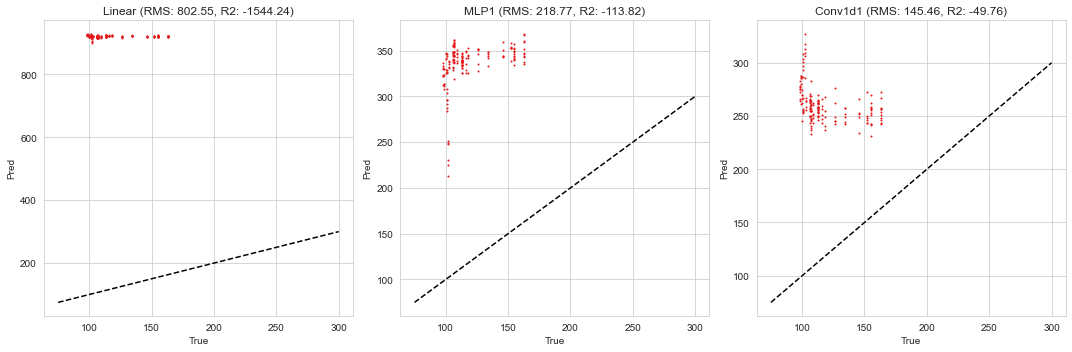

In [8]:
import numpy
import csv

import matplotlib.pyplot as plt
import seaborn as sns

test_loader = DataLoader(TensorDataset(datas[2].unsqueeze(1), datas[3]), batch_size=1, shuffle=True)

sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1) = plt.subplots(1, 3, figsize=(15, 5))

y_pred_l, y_true_l, rms, r2 = model_infer(model_linear, test_loader)
append_graph(ax1[0], y_true_l, y_pred_l, 'Linear')
y_pred_m, y_true_m, rms, r2 = model_infer(model_mlp, test_loader)
append_graph(ax1[1], y_true_m, y_pred_m, 'MLP1')
y_pred_c, y_true_c, rms, r2 = model_infer(model_conv, test_loader)
append_graph(ax1[2], y_true_c, y_pred_c, 'Conv1d1')


plt.tight_layout()
plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

RF = RandomForestClassifier(max_depth=20, n_estimators=100, random_state=0)

In [10]:
def model_infer(model, loder) -> tuple:
    y_pred = []
    y_true = []

    for X, y in loder:
        y_hat = model.predict(X.squeeze(0).tolist()) # model(X)
        y_hat = torch.Tensor(y_hat)
        y_pred.append(y_hat.cpu().numpy())
        y_true.append(y.cpu().numpy())
        
    y_pred = numpy.concatenate(y_pred)
    y_true = numpy.concatenate(y_true)
    rms = numpy.sqrt(mean_squared_error(y_true, y_pred.squeeze()))
    r2 = r2_score(y_true, y_pred.squeeze())
    return y_pred, y_true, rms, r2

def draw_DTgraph(ax, model, loader, title):
    y_pred, y_true, rms, r2 = model_infer(model, loader)
    ax.scatter(y_true, y_pred, s=1, label=title)
    ax.plot([75, 300], [75, 300], 'k--')
    ax.set_xlabel('True')
    ax.set_ylabel('Pred')
    ax.set_title(f'{title} (RMS: {rms:.2f}, R2: {r2:.2f})') # f'R31 RandomForest (RMS: {rms:.2f}, R2: {r2:.2f})'

In [11]:
num_epochs = 3

for epoch in tqdm(range(num_epochs), desc=f'Train {str}'):
    RF.fit(datas[0], datas[1])

Train <class 'str'>: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s]


0.0


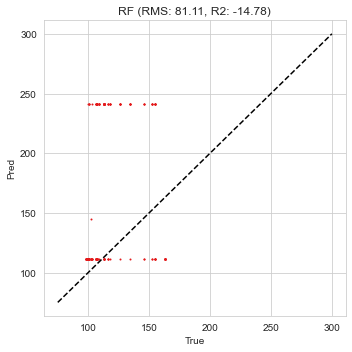

In [12]:
print(RF.score(datas[2], datas[3]))

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
draw_DTgraph(ax1, RF, test_loader, 'RF')

plt.tight_layout()
plt.show()